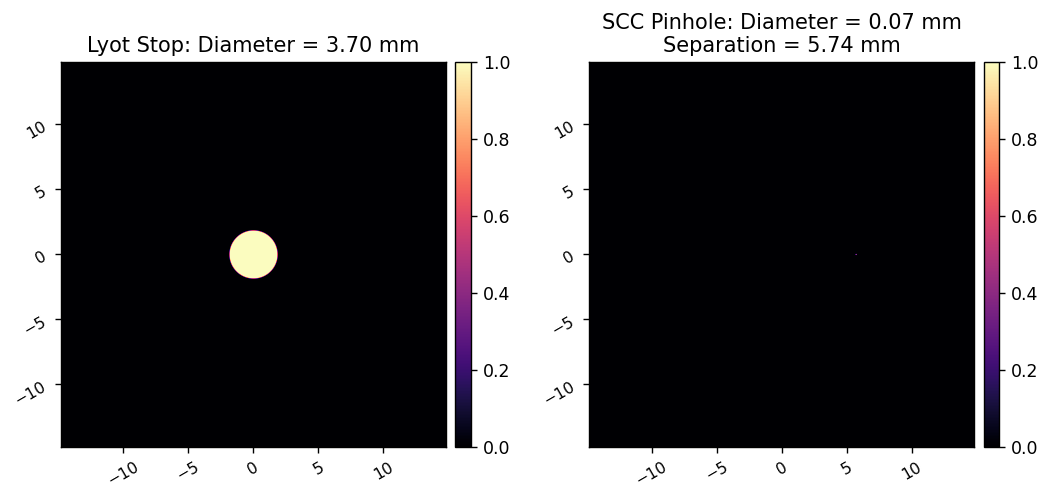

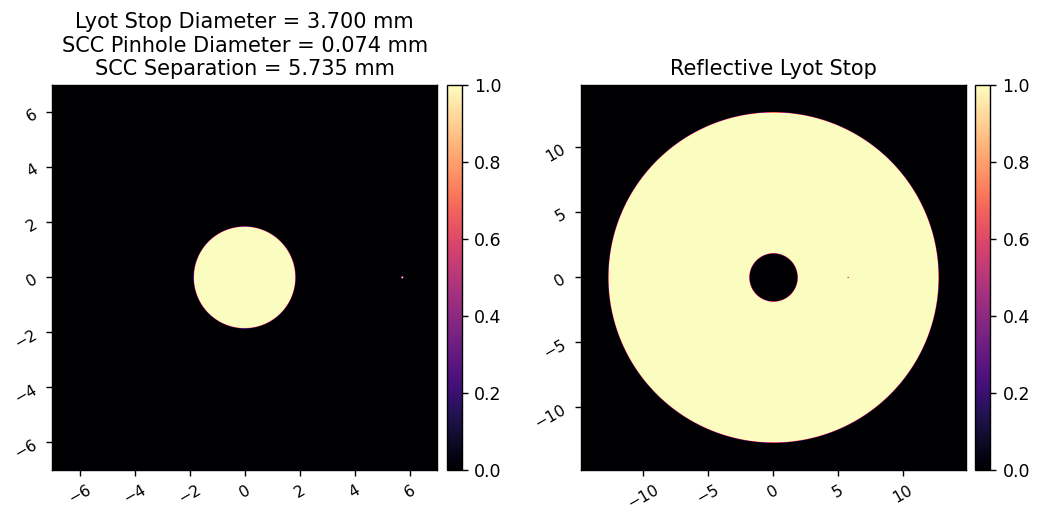

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import astropy.units as u
from astropy.io import fits
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


from importlib import reload


import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import scoobpsf
from scoobpsf.math_module import xp, _scipy
from scoobpsf.imshows import *
from scoobpsf import scoob

pupil_diam = 6.75*u.mm 

wavelength_c = 632.8e-9*u.m # central wavelength

reload(scoobpsf.agpm)
vortex = scoobpsf.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)

lyot_diam = 8.6*u.mm # nominal for current testbed
scc_center = 1.55*lyot_diam
scc_diam = 0.03*lyot_diam

lyot_diam = 7.1*u.mm # nominal for current testbed
scc_center = 1.55*lyot_diam
scc_diam = 0.03*lyot_diam

lyot_diam = 3.7*u.mm # nominal for current testbed
scc_center = 1.55*lyot_diam
scc_diam = 0.02*lyot_diam

# lyot_diam = 6*u.mm
# scc_center = 2*lyot_diam

wf = poppy.FresnelWavefront(beam_radius=lyot_diam/2, npix=512, oversample=8)

lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2.0,)
lyot_ap = lyot_stop.get_transmission(wf)

scc_pinhole = poppy.CircularAperture(name='SCC Pinhole', radius=scc_diam/2, shift_x=scc_center)
scc_ap = scc_pinhole.get_transmission(wf)

reflective_lyot_stop_edge = poppy.CircularAperture(radius=12.7*u.mm)
lyot_edge = reflective_lyot_stop_edge.get_transmission(wf)

scc_lyot_stop = poppy.ArrayOpticalElement(transmission=lyot_ap+scc_ap, pixelscale=wf.pixelscale, name='Lyot/SCC Mask')
imshow2(lyot_ap, scc_ap, f'Lyot Stop: Diameter = {lyot_diam:.2f}', 
        f'SCC Pinhole: Diameter = {scc_diam:.2f}\nSeparation = {scc_center:.2f}', 
        pxscl=scc_lyot_stop.pixelscale.to(u.mm/u.pix))

llowfsc_lyot_stop = poppy.ArrayOpticalElement(transmission=(1-(lyot_ap+scc_ap))*lyot_edge, pixelscale=wf.pixelscale, name='Lyot/SCC Mask')
imshow2(scc_lyot_stop.amplitude, llowfsc_lyot_stop.amplitude,
        f'Lyot Stop Diameter = {lyot_diam:.3f}\nSCC Pinhole Diameter = {scc_diam:.3f}\nSCC Separation = {scc_center:.3f}', 'Reflective Lyot Stop', 
        pxscl=llowfsc_lyot_stop.pixelscale.to(u.mm/u.pix),
        axlims1=np.array([-6, 6, -6, 6])*7/6)


In [70]:
11/1.55

7.096774193548387

In [7]:
scc_model.psf_pixelscale, scc_model.psf_pixelscale_lamD

(<Quantity 3.76 um / pix>, 0.18051670532333897)

Model using synthetic OPD data
Using default Gaussian influence function.
Using reflection when computing OPD.
3.76 um / pix 0.0721287051507942


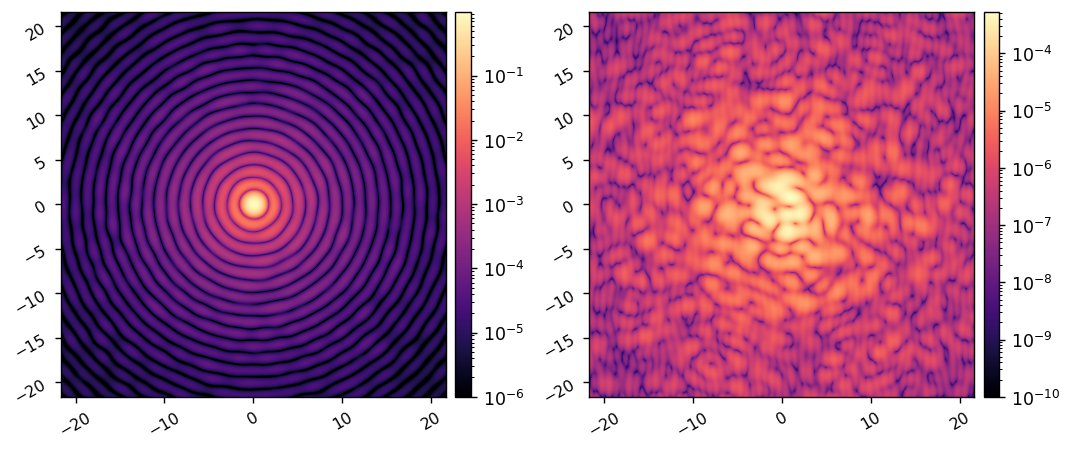

Propagating wavelength 632.800 nm.
PSF calculated in 0.257s


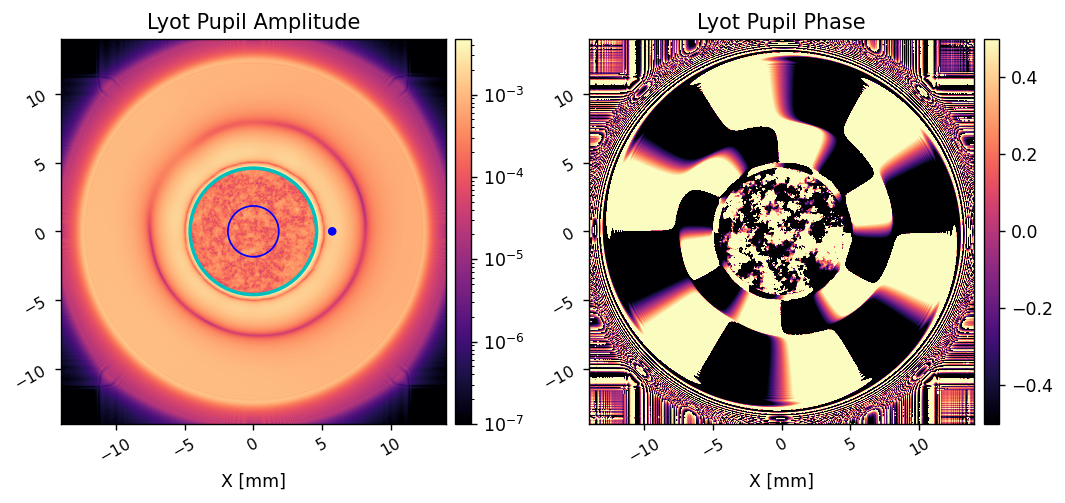

In [2]:
reload(scoob)
scc_model = scoob.SCOOBM(oversample=8, 
                         npsf=600,
                         lyot_diam=lyot_diam,
                         use_synthetic_opds=True,
                        )
scc_model.LYOT = scc_lyot_stop

scc_model.FPM = None
scc_model.Imax_ref = xp.max(scc_model.snap())
ref_psf = scc_model.snap()


print(scc_model.psf_pixelscale, scc_model.psf_pixelscale_lamD)

scc_model.FPM = vortex
ref_im = scc_model.snap()
imshow2(ref_psf, ref_im, lognorm=True, pxscl=scc_model.psf_pixelscale_lamD, vmin1=1e-6, vmin2=1e-10)

wfs = scc_model.calc_wfs()

names = [wf.location for wf in wfs]
# display(names)

for i,name in enumerate(names):
    if 'DM' in name: dm_ind = i
    if 'Lyot Pupil' in name: lyot_ind = i

pup_circ = Circle((0, 0), 9.2/2, color='c', fill=False, linewidth=2)
lyot_circ = Circle((0, 0), lyot_diam.to_value(u.mm)/2, color='b', fill=False)
scc_circ = Circle((scc_pinhole.shift_x.to_value(u.mm), 0), 1/4, color='b')
imshow2(wfs[lyot_ind].amplitude, wfs[lyot_ind].phase, 'Lyot Pupil Amplitude', 'Lyot Pupil Phase',
        # npix=4*model.npix,
        lognorm1=True, vmin1=1e-7,
        xlabel='X [mm]', 
        axlims=np.array([-14,14,-14,14]),
        patches1=[pup_circ, lyot_circ, scc_circ],
         vmin2=-0.5, vmax2=0.5, pxscl=wfs[lyot_ind].pixelscale.to(u.mm/u.pix))

In [5]:
angle = 5*u.degree

v_diam = lyot_diam
h_diam = lyot_diam/np.cos(angle)
print(v_diam, h_diam)


3.7 mm 3.7141333989103855 mm


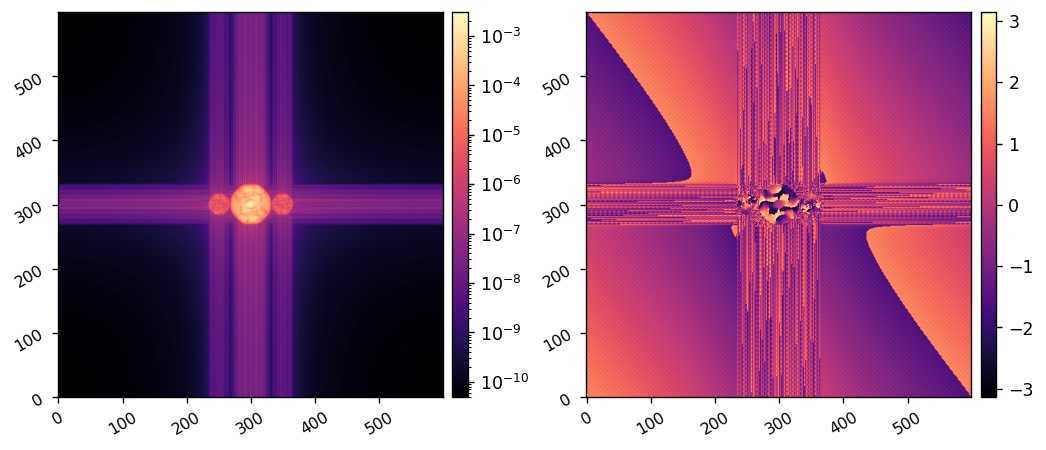

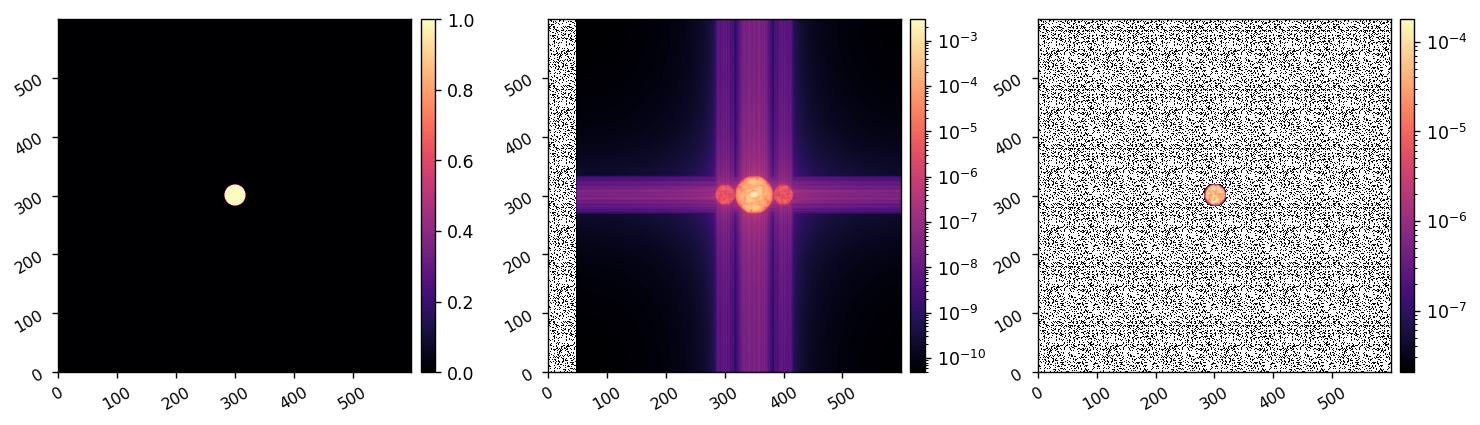

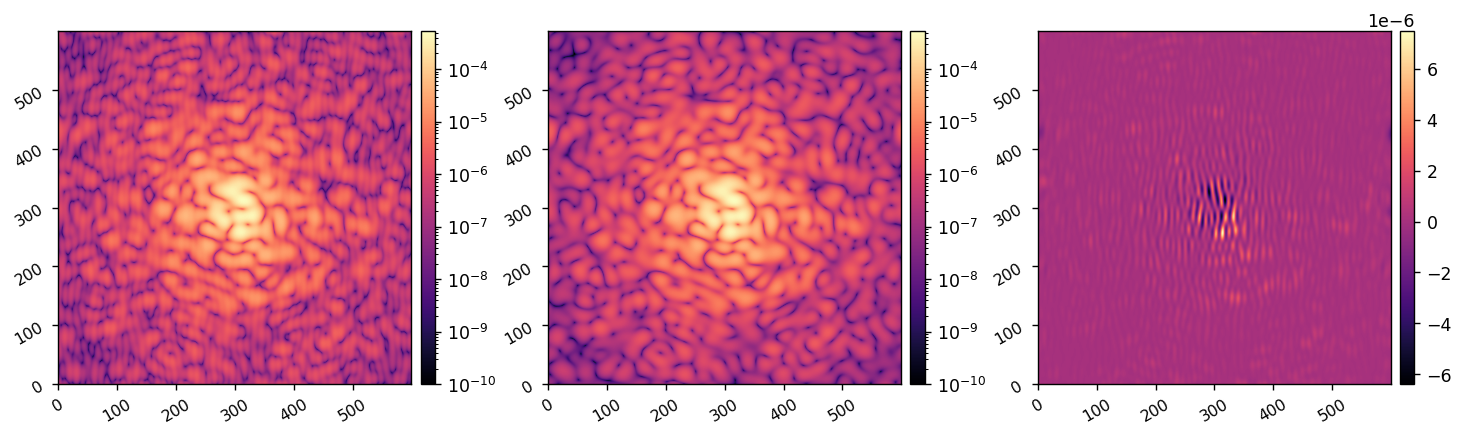

In [8]:
import lina

E_est = lina.scc.estimate_coherent(scc_model, r_npix=18, shift=(0,49), 
                                #    dark_mask=control_mask, 
                                   plot=True)

I_est = 1.5*xp.abs(E_est)**2
imshow3(ref_im, I_est, ref_im-I_est, lognorm1=True, lognorm2=True, vmin1=1e-10, vmin2=1e-10)

Model using synthetic OPD data
Using default Gaussian influence function.
Using reflection when computing OPD.


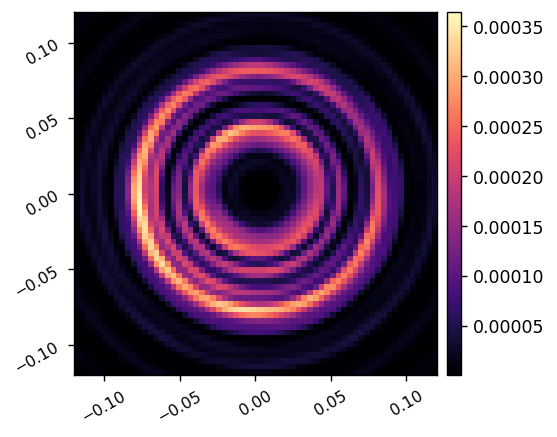

In [13]:
reload(scoob)
llowfsc_model = scoob.SCOOBM(npix=256, oversample=32,
                             use_synthetic_opds=True, 
                            )

llowfsc_model.fl_llowfsc_lens = 300*u.mm

llowfsc_model.use_llowfsc = True
llowfsc_model.llowfsc_defocus = 2*u.mm
llowfsc_model.nllowfsc = 64

llowfsc_model.FPM = vortex
llowfsc_model.LYOT = llowfsc_lyot_stop

llowfsc_model.reset_dm()
im = llowfsc_model.snap()
imshow1(im, pxscl=llowfsc_model.llowfsc_pixelscale.to(u.mm/u.pix))

# old image
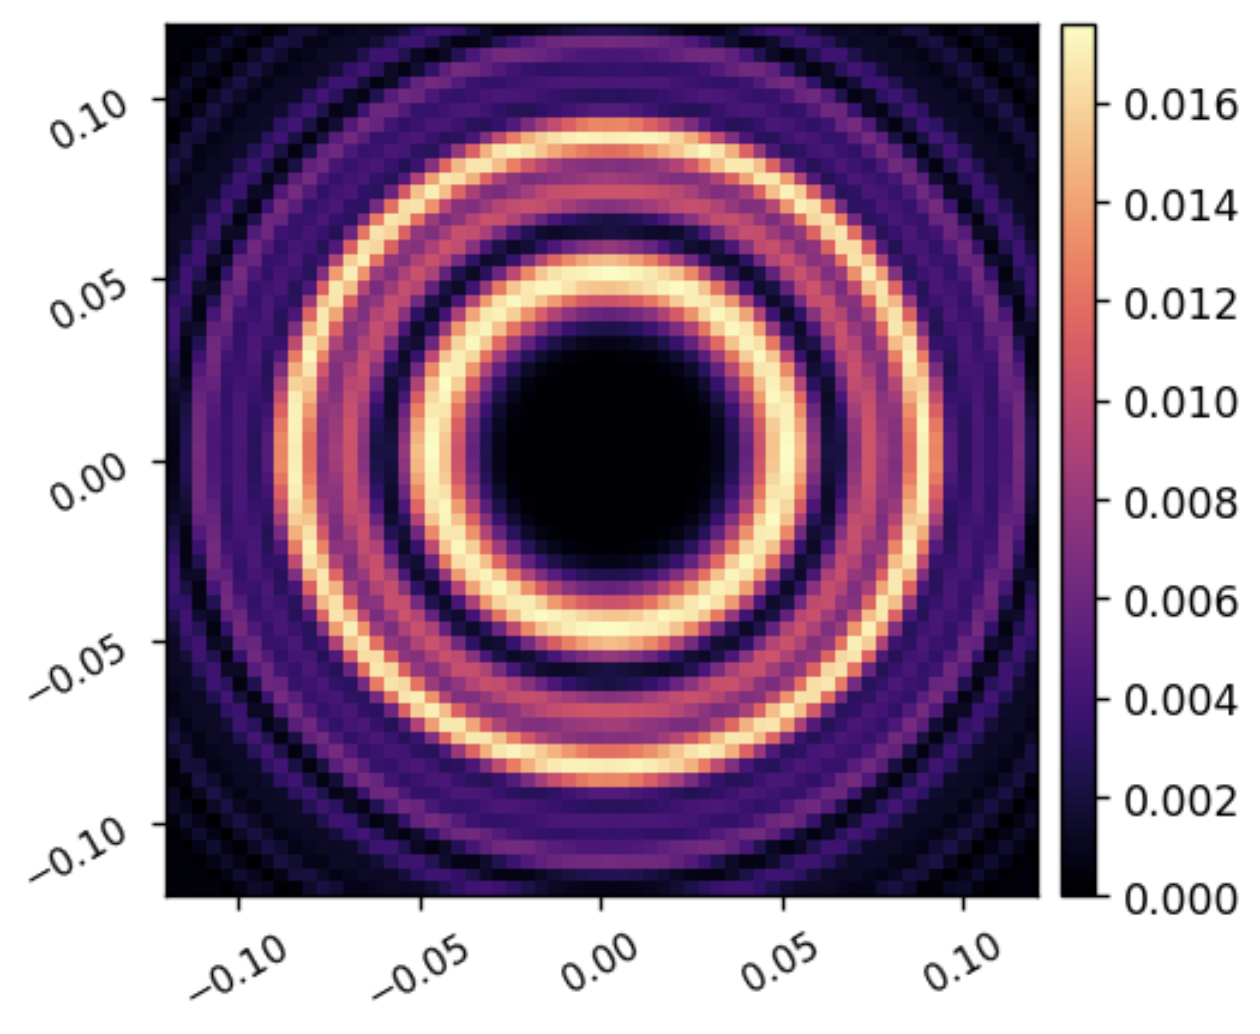

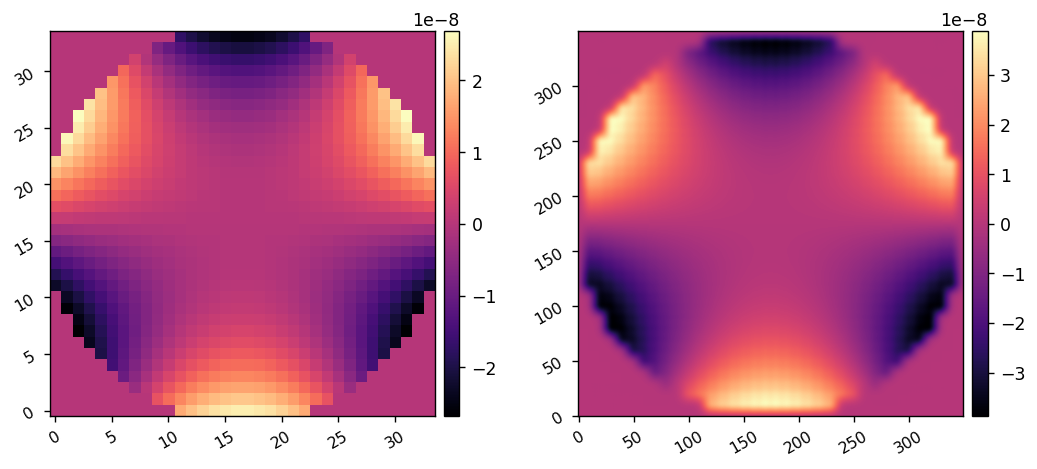

In [16]:
nmodes = 25

reload(lina)
dm_zernikes = lina.llowfsc.create_zernike_modes(llowfsc_model.dm_mask, nmodes=25 + 1)[1:]
llowfsc_model.set_dm(dm_zernikes[7]*1e-8)
imshow2(dm_zernikes[7]*1e-8, llowfsc_model.DM.get_surface())

llowfsc_model.reset_dm()




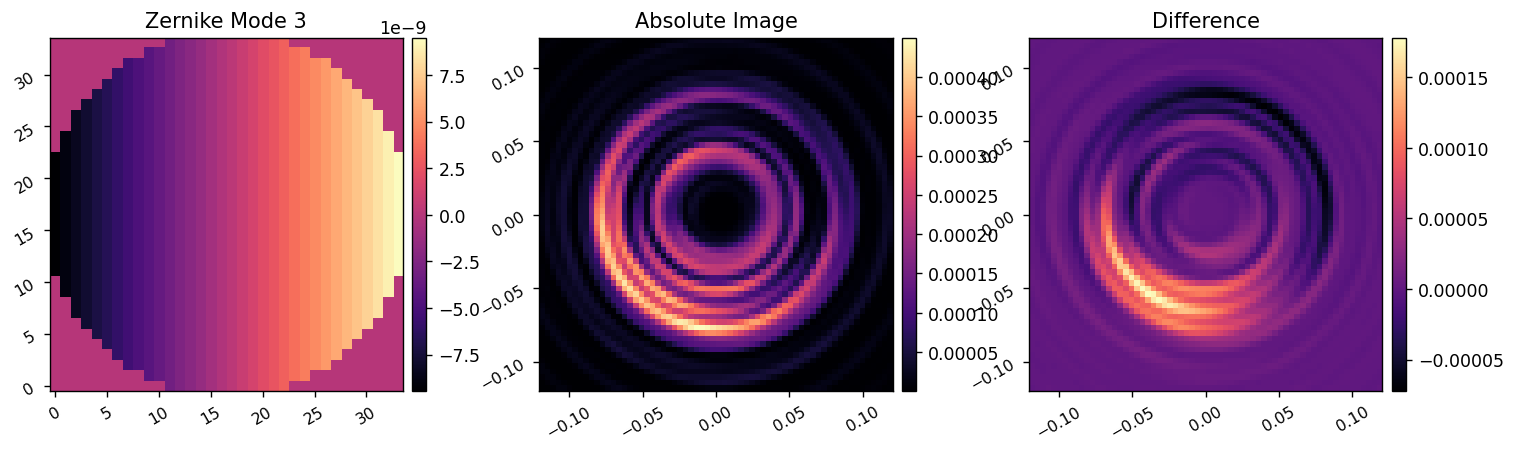

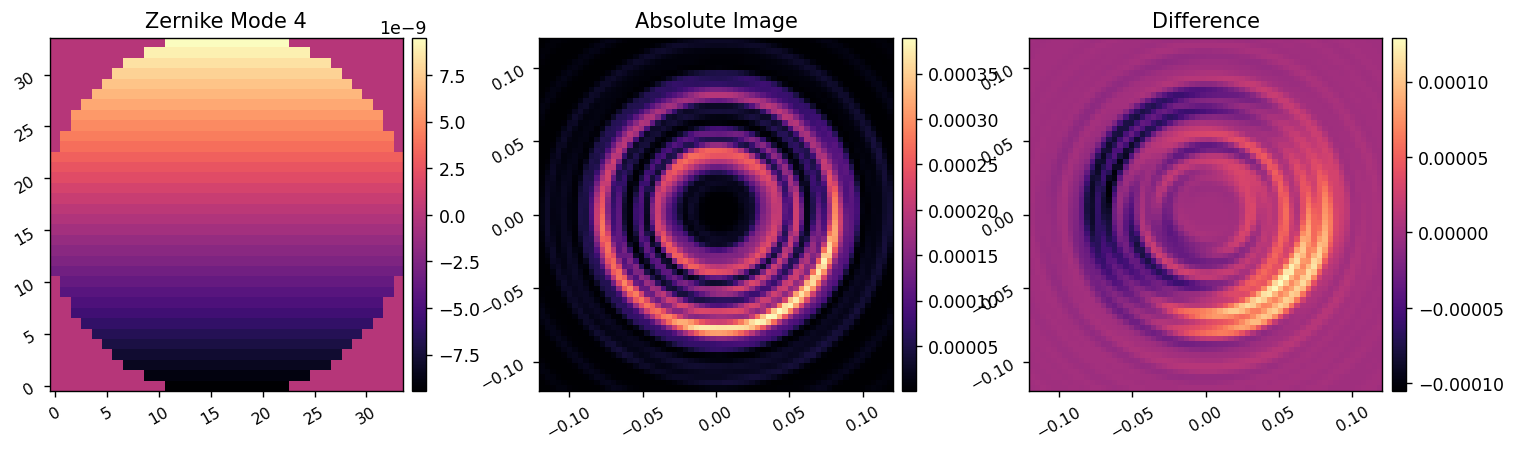

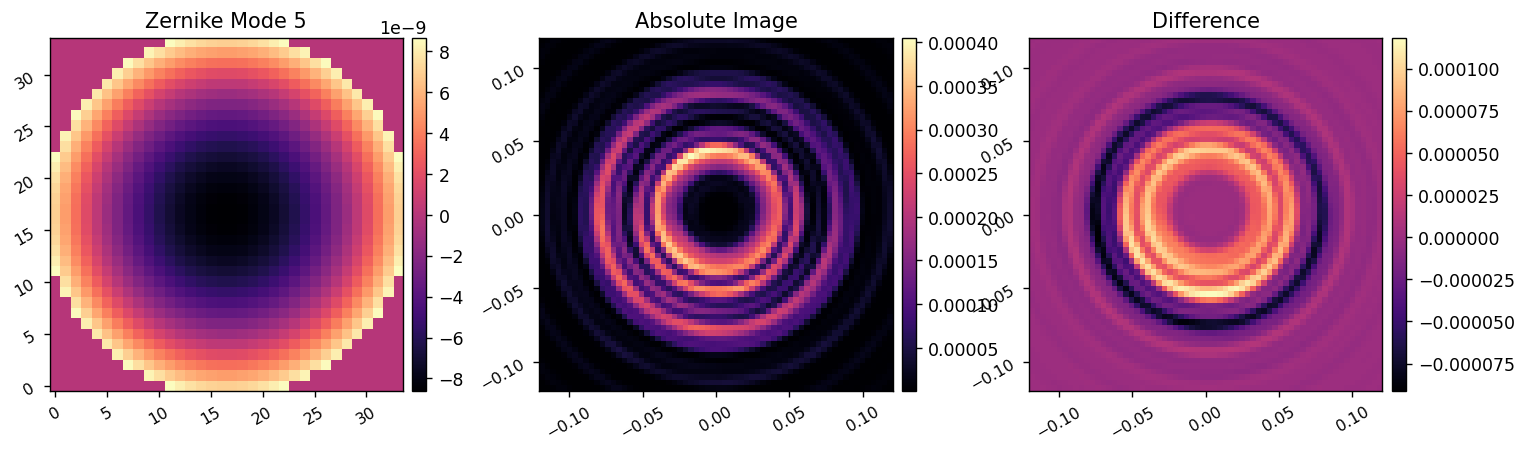

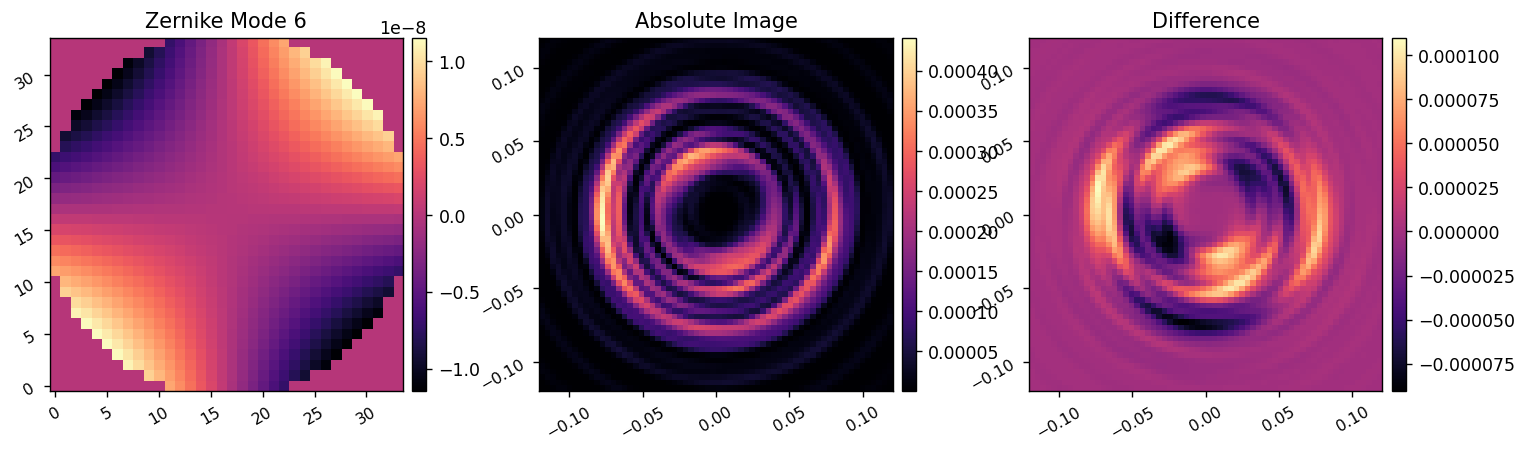

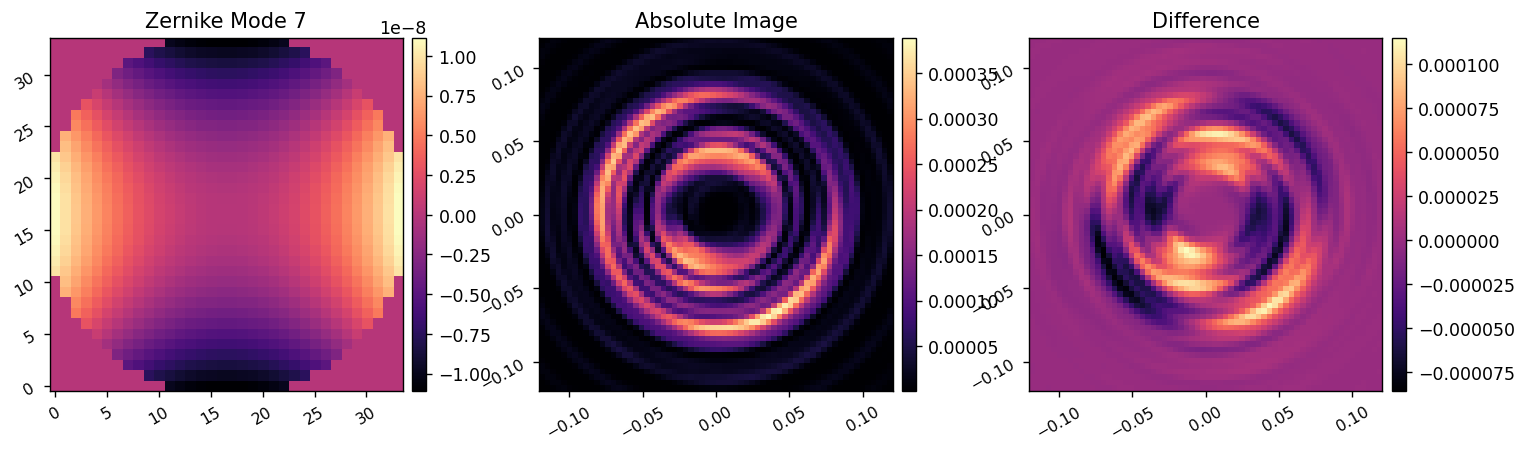

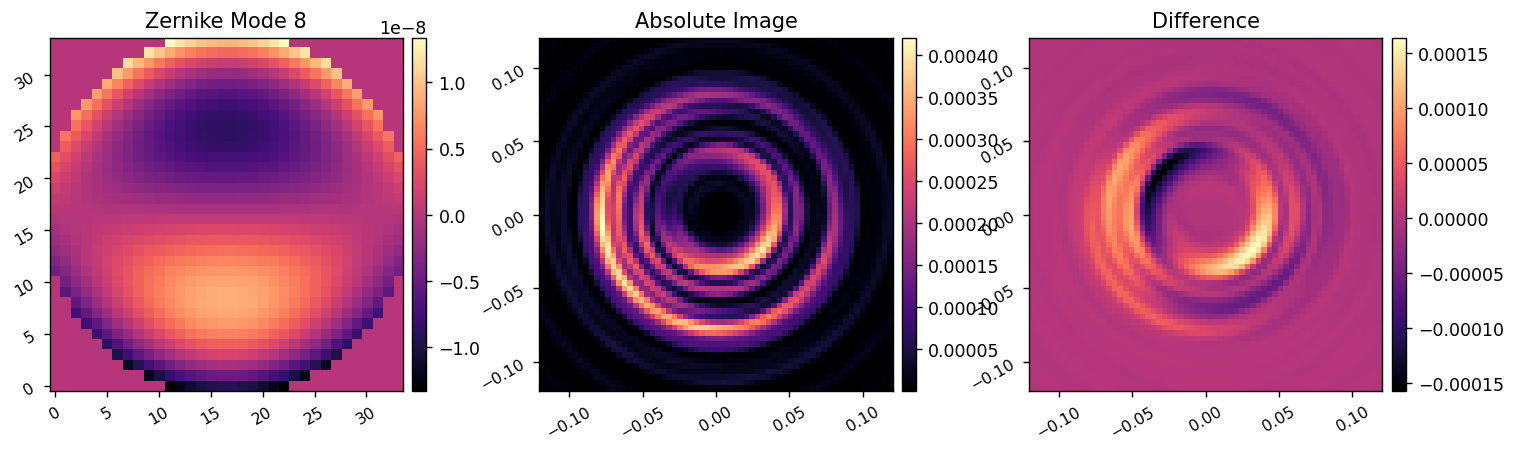

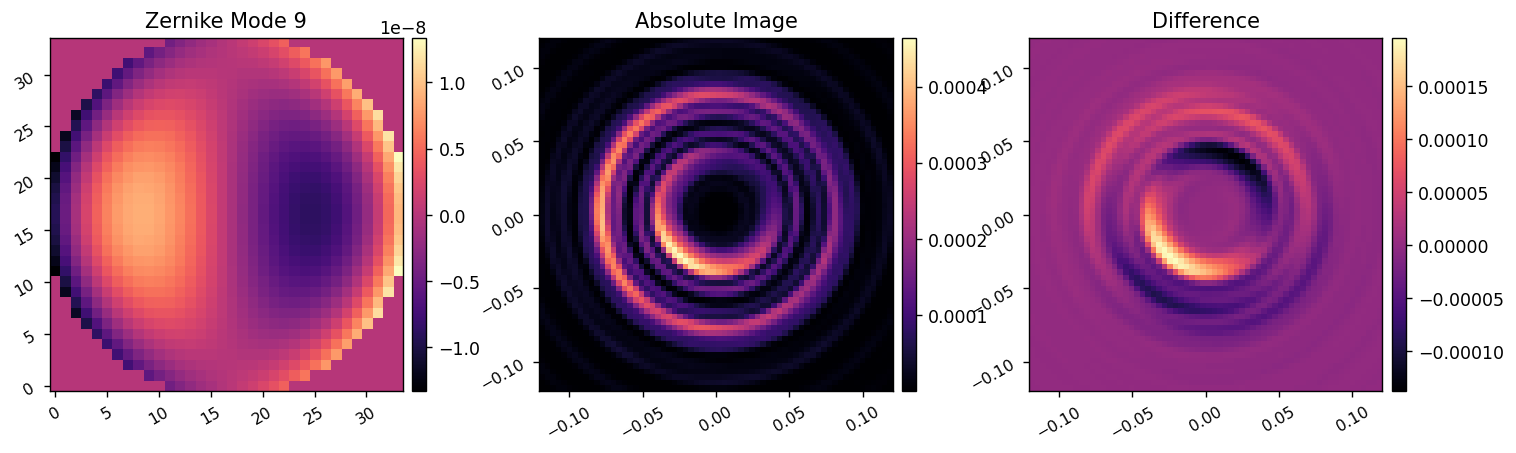

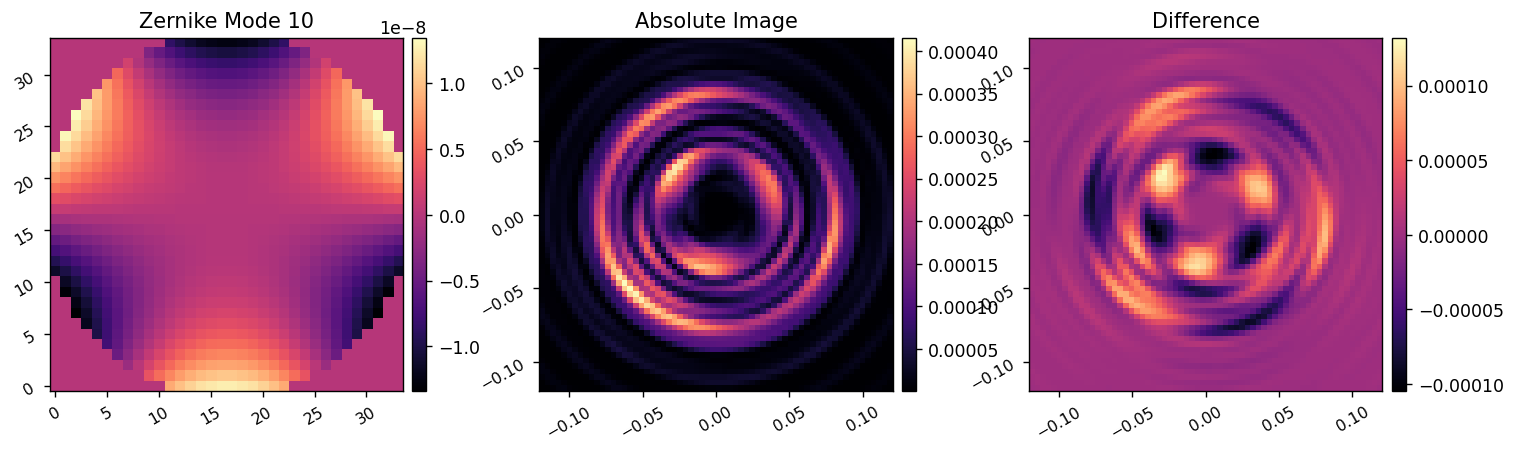

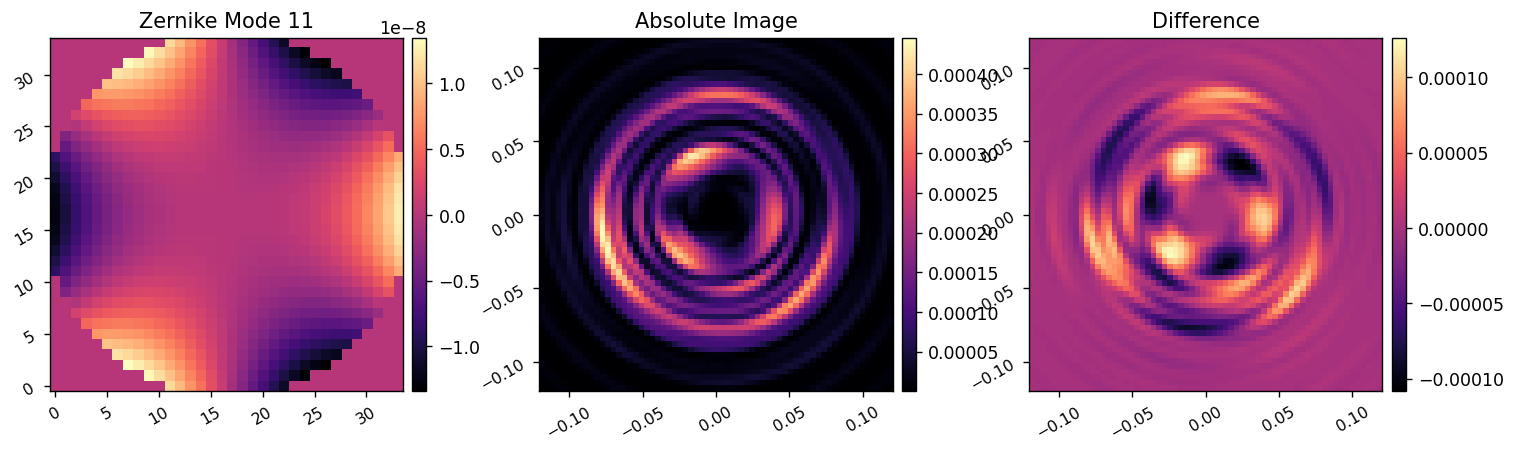

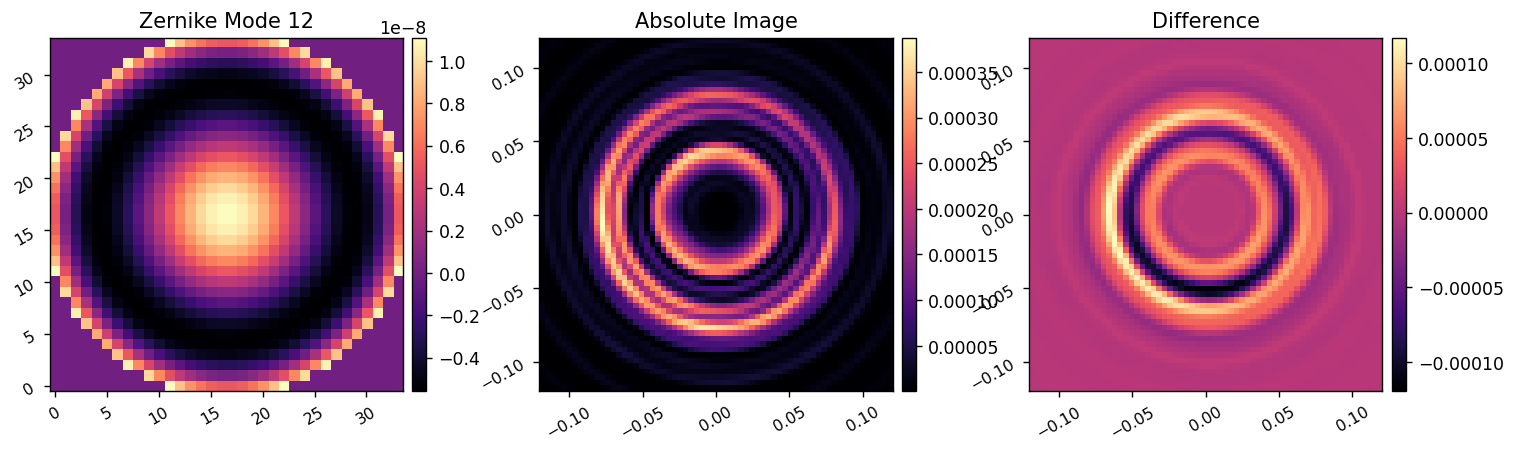

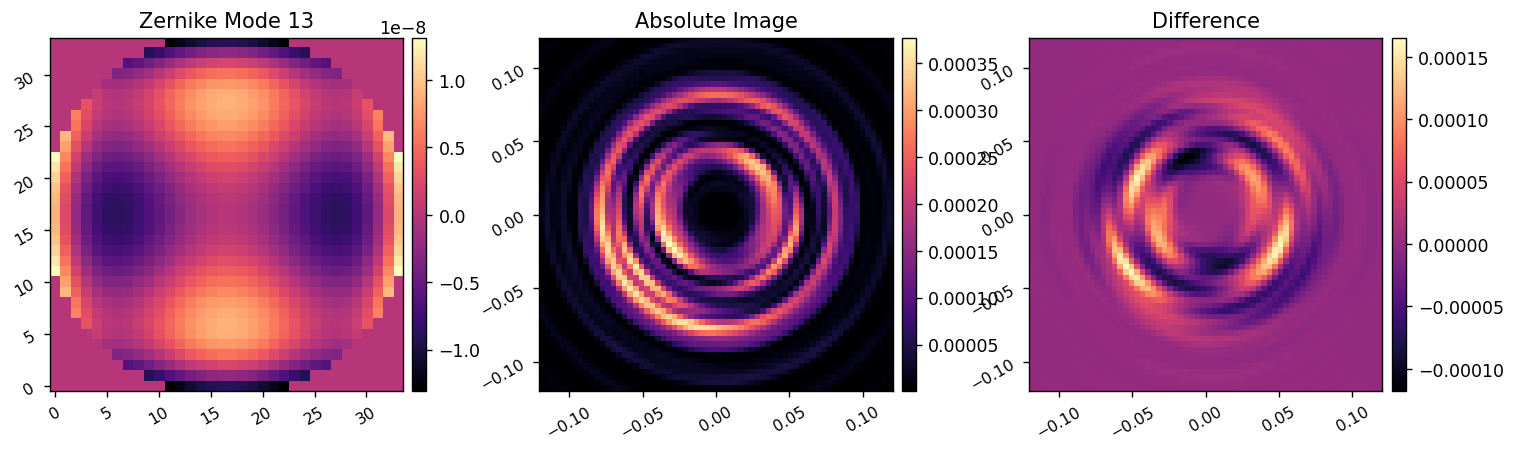

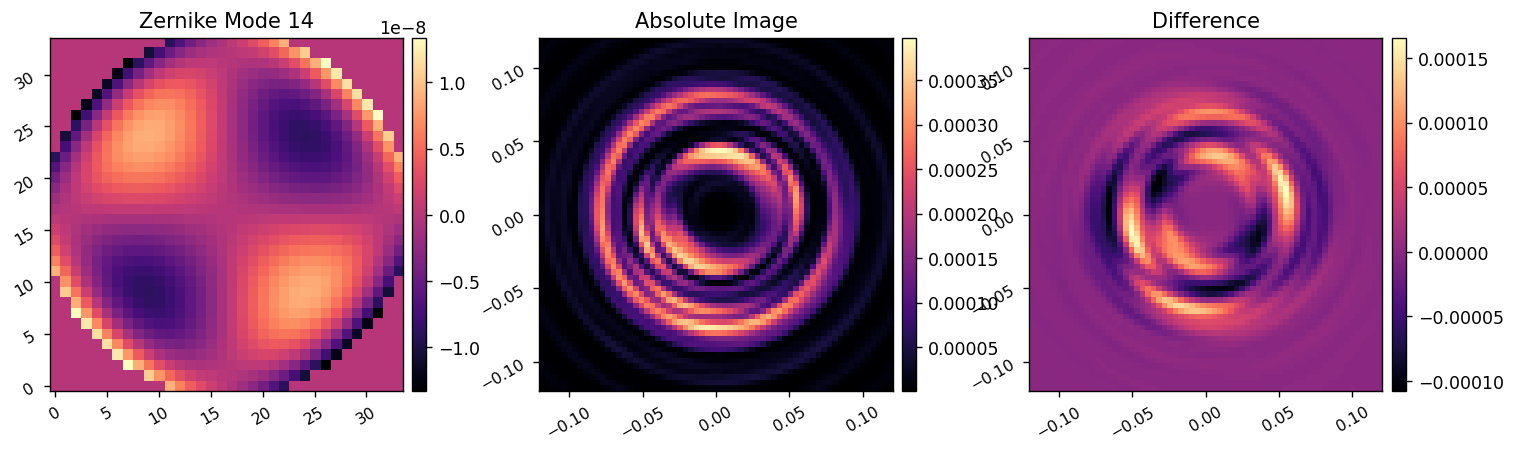

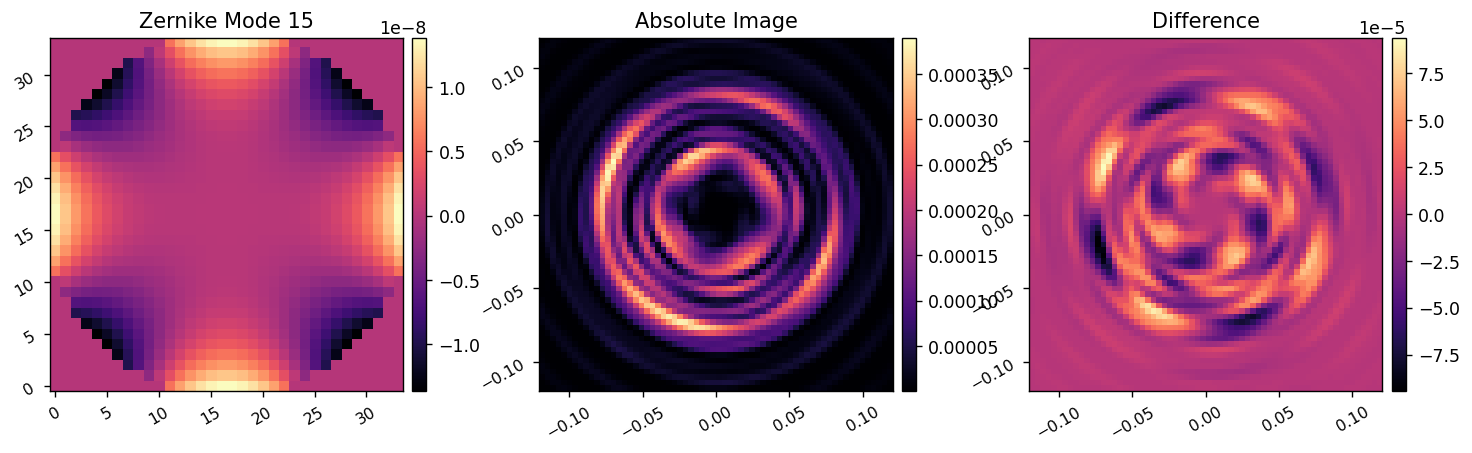

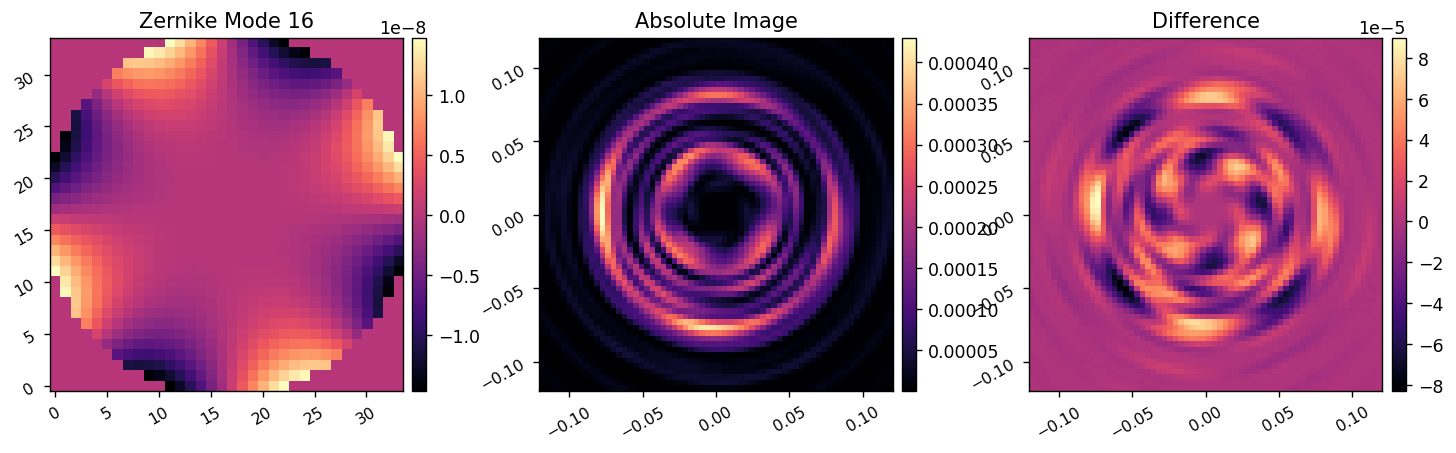

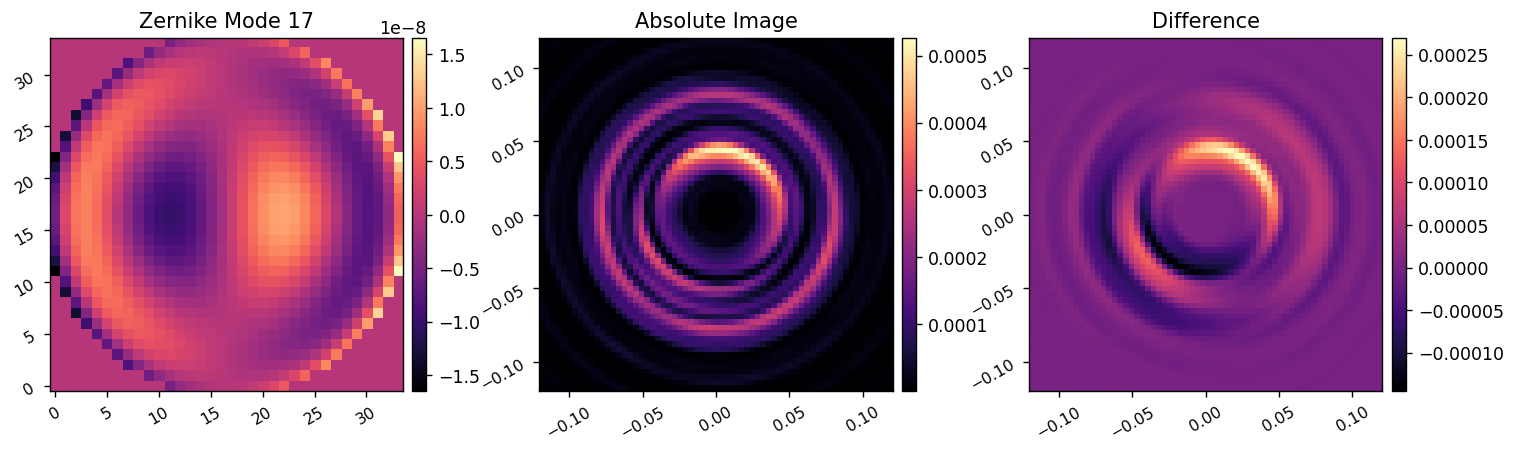

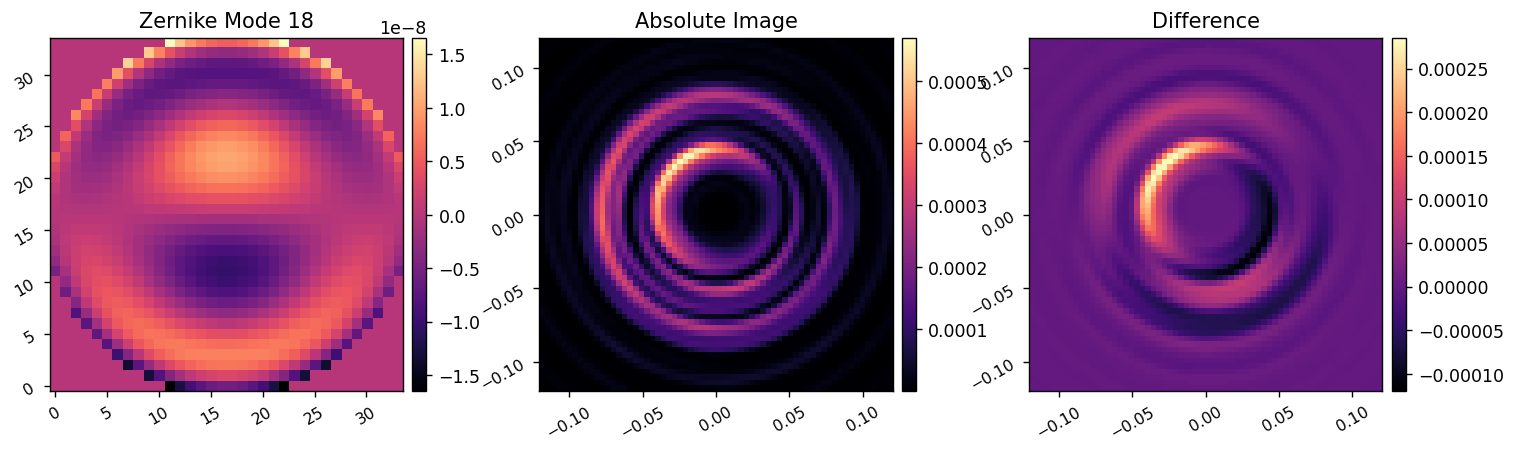

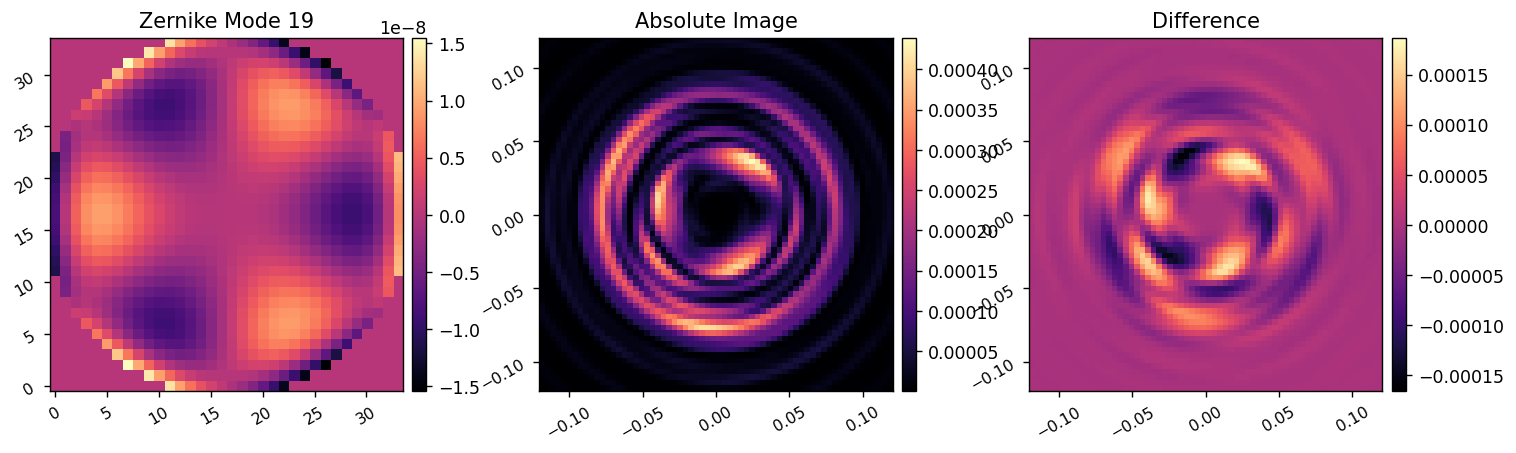

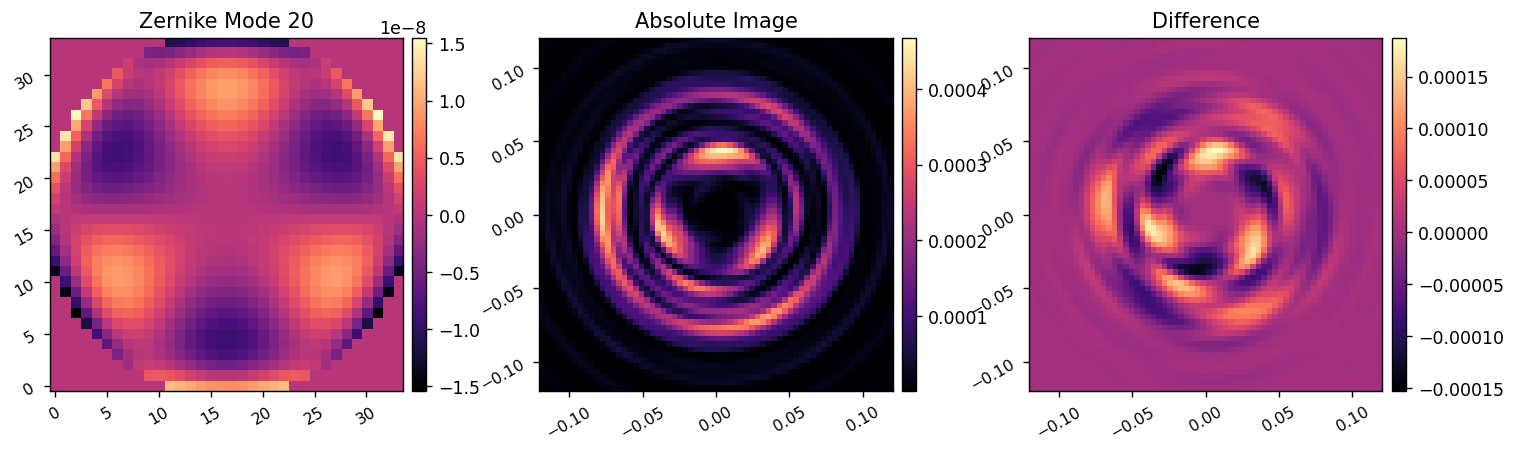

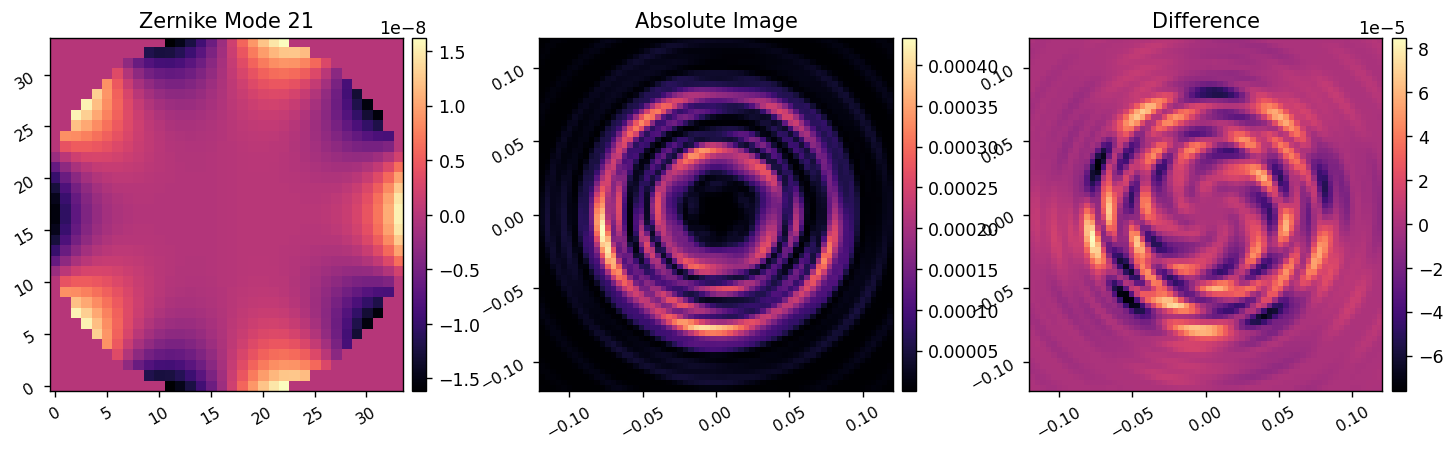

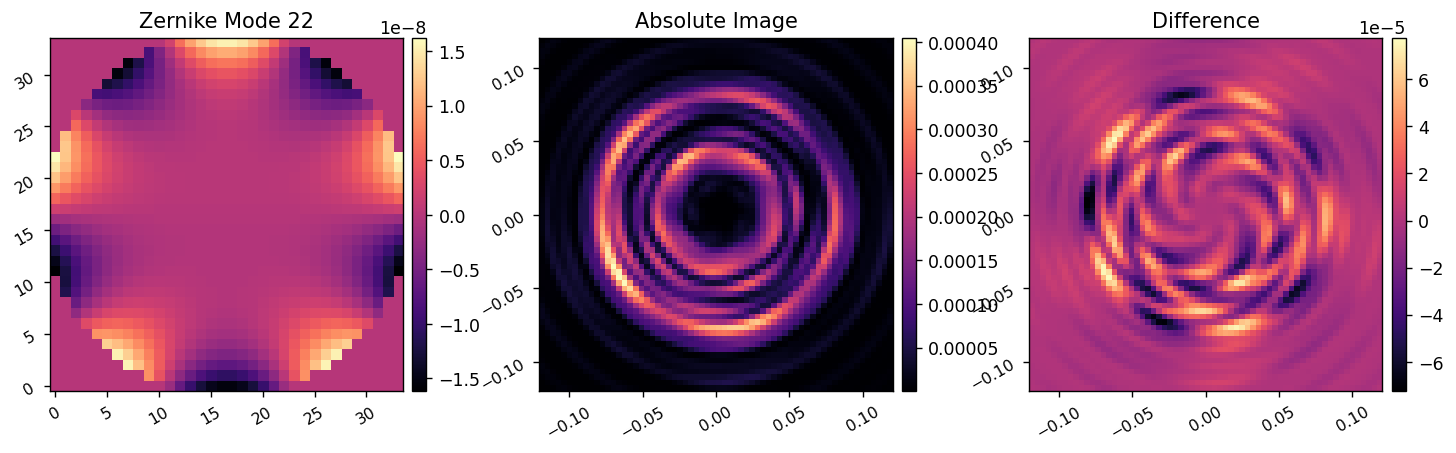

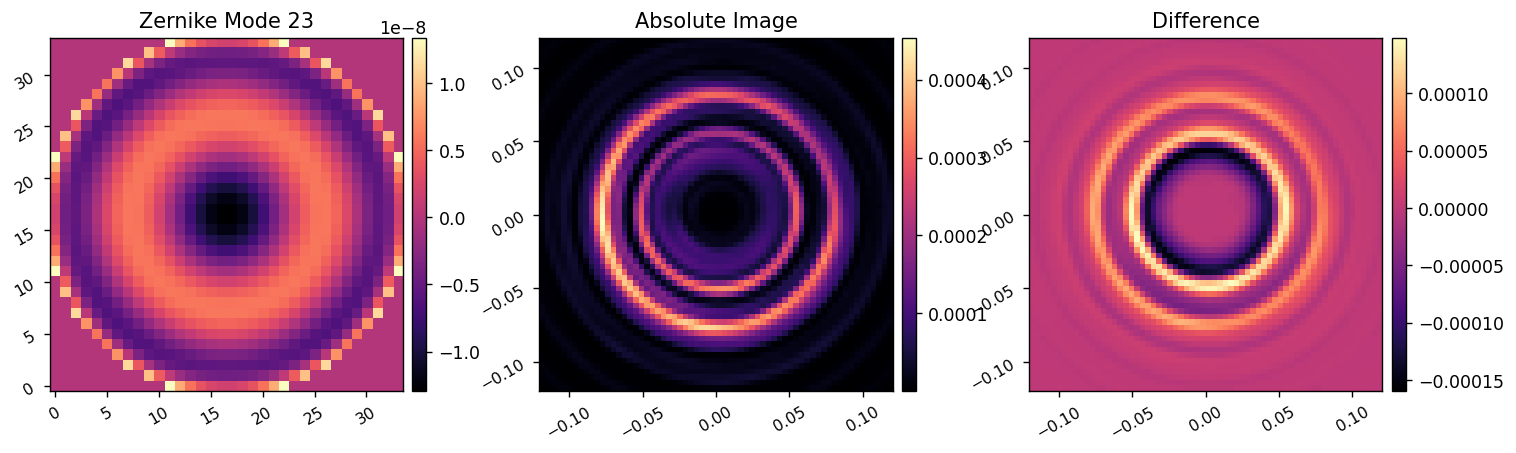

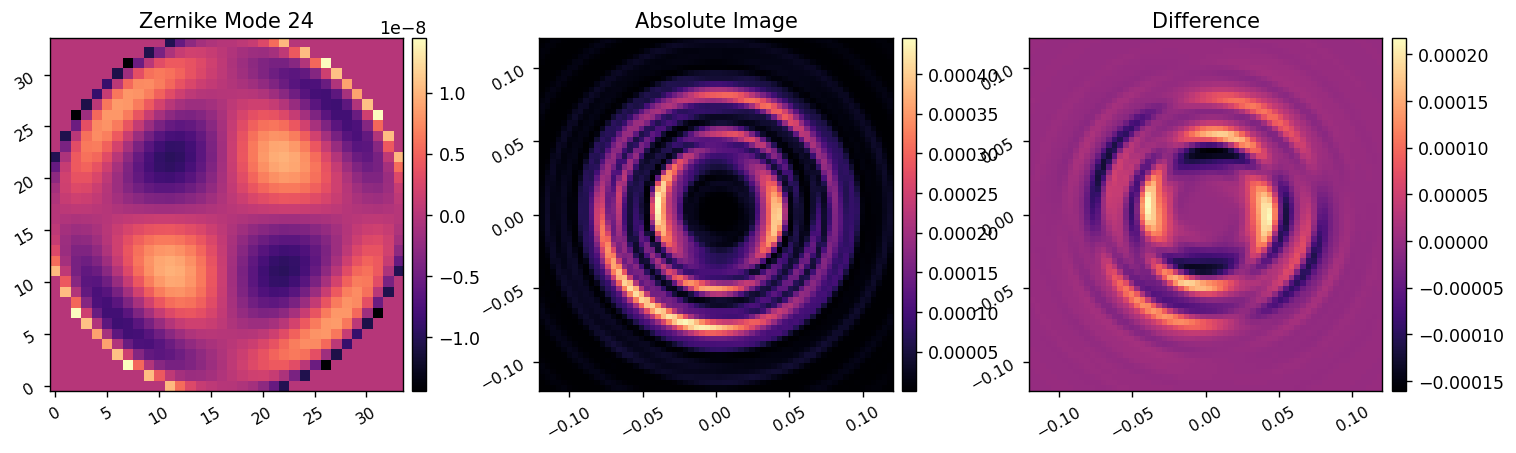

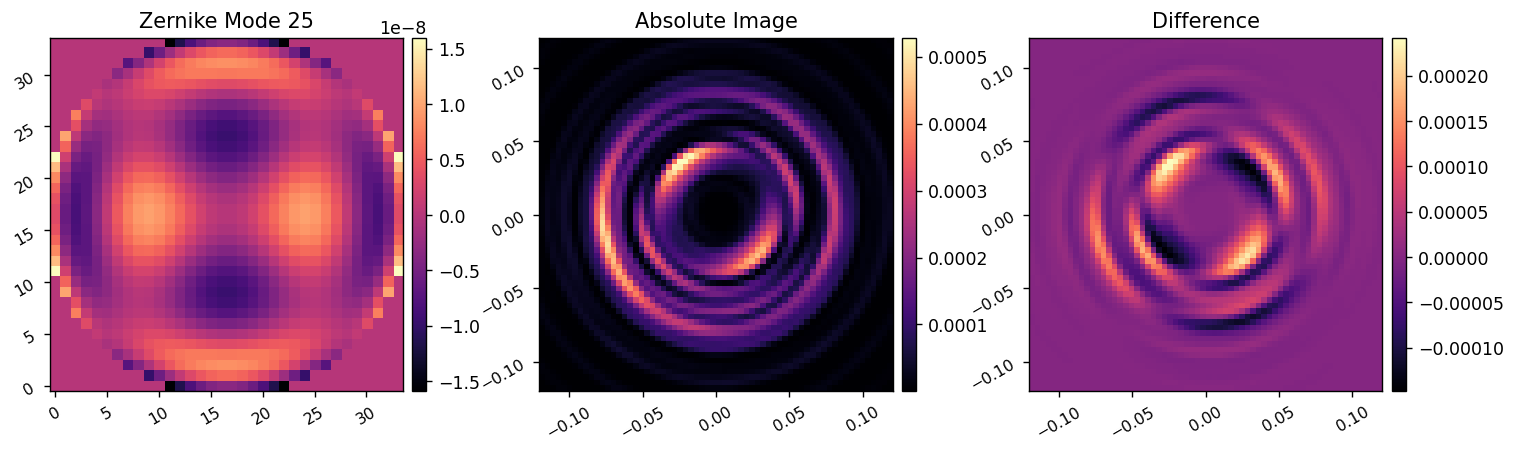

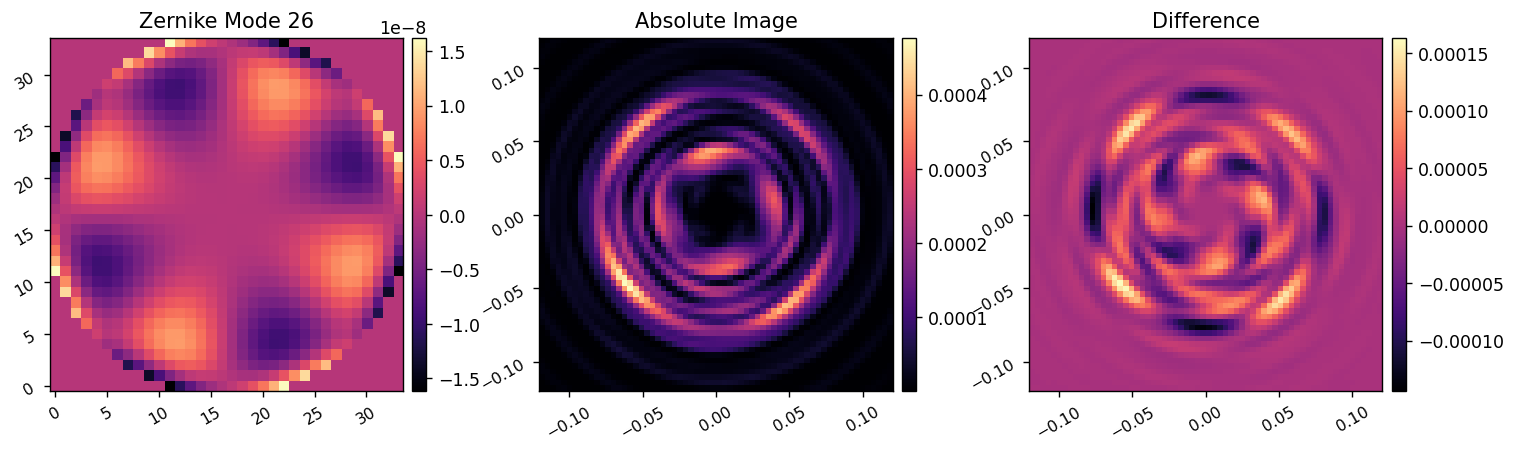

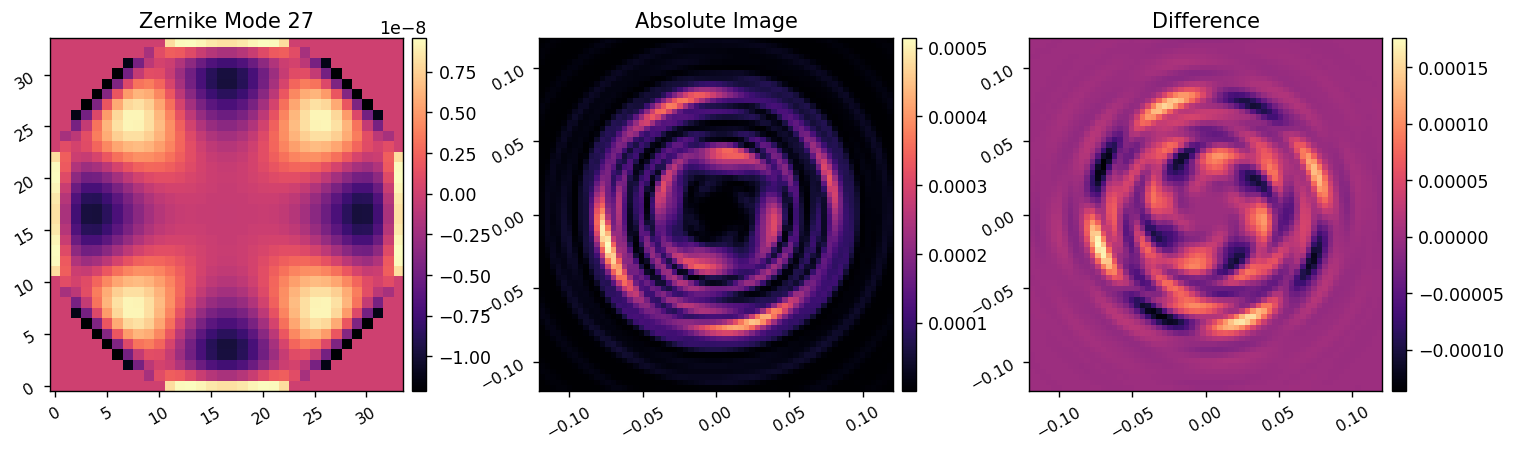

In [17]:
amp = 5e-9

im_ref = llowfsc_model.snap()

responses = xp.zeros((nmodes, llowfsc_model.nllowfsc**2))
for i,mode in enumerate(dm_zernikes):
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    llowfsc_model.set_dm(amp*mode)
    im_pos = llowfsc_model.snap()
    llowfsc_model.add_dm(-amp*mode)

    # model.add_dm(-amp*mode)
    # im_neg = model.snap()
    # model.add_dm(amp*mode)

    diff = im_pos-im_ref
    responses[i] = diff.flatten()/amp

    # diff = im_pos - im_neg
    # responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+3}', 'Absolute Image', 'Difference', 
            pxscl2=llowfsc_model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=llowfsc_model.llowfsc_pixelscale.to(u.mm/u.pix))

response_matrix = responses.T


array([ 1.17793339e-09, -1.16846312e-09, -6.41410292e-09,  3.51715322e-09,
       -2.49940265e-09,  1.84075074e-10, -3.41845732e-09, -1.40511174e-10,
       -3.88207713e-10,  1.92066699e-09,  1.88508191e-10,  6.23211362e-09,
        1.62158647e-09,  2.56726400e-09,  5.65432253e-09,  3.41109957e-09,
       -5.78459304e-09,  2.46221169e-09,  4.72096185e-10,  8.48348674e-09,
       -9.83695669e-10,  3.69785414e-09, -6.74552709e-09, -4.52864200e-10,
       -3.45177142e-09])

1.880883716686009e-08


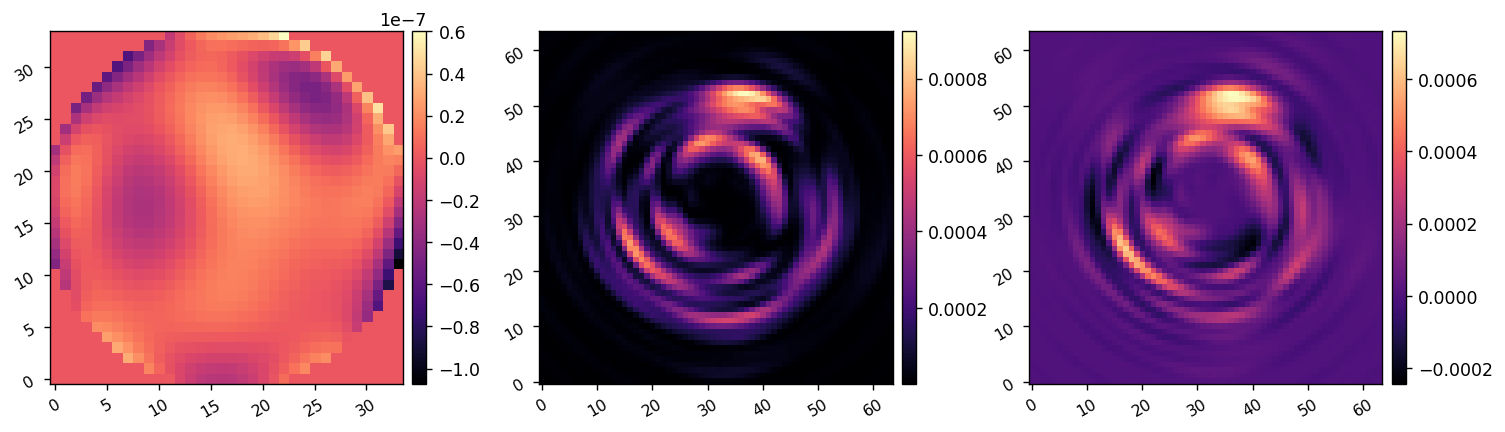

In [19]:
amps = 5e-9*(np.random.randn(nmodes))
display(amps)

rss = xp.sqrt(xp.sum(amps**2))
print(rss)

lo_wfe = 0
for i in range(dm_zernikes.shape[0]):
    lo_wfe += amps[i]*dm_zernikes[i]
    # lo_wfe += amps[i]*zmodes[i]

llowfsc_model.set_dm(lo_wfe)
# model.RETRIEVED = poppy.ArrayOpticalElement(opd=lo_wfe, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
llowfsc_model.RETRIEVED = None
im = llowfsc_model.snap()

diff = im - im_ref

imshow3(lo_wfe, im, diff)

In [27]:
# control_matrix = lina.utils.beta_reg(response_matrix, -1)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-3)

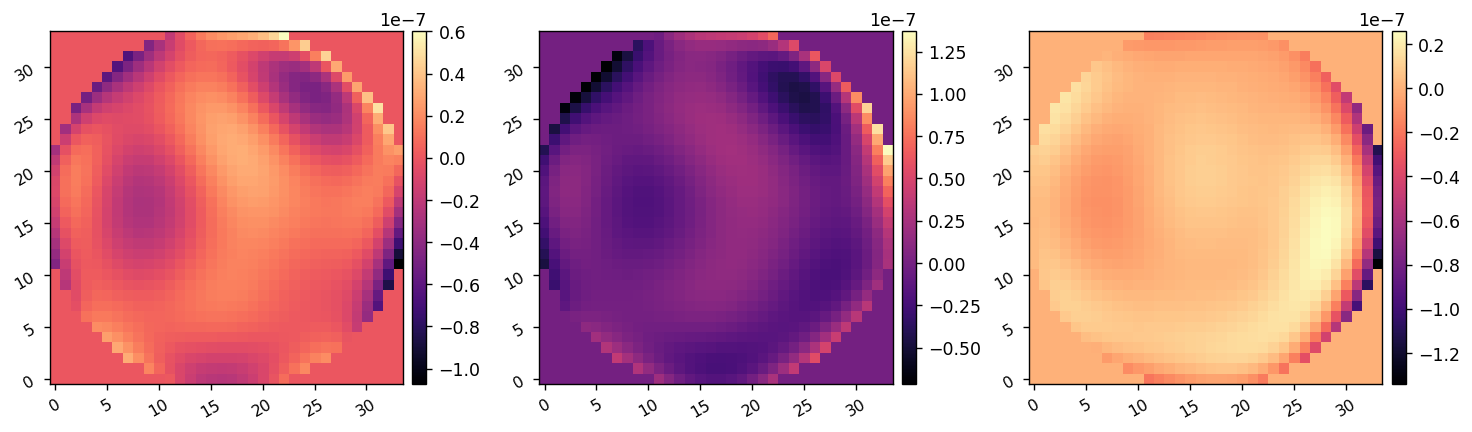

In [28]:
modal_coeff = control_matrix.dot(diff.flatten())

est_lo_wfe = 0
for i in range(len(modal_coeff)):
    # est_lo_wfe += modal_coeff[i]*zmodes[i]
    est_lo_wfe += modal_coeff[i]*dm_zernikes[i]
imshow3(lo_wfe, est_lo_wfe, lo_wfe-est_lo_wfe)